**Step 1: Load Data and Perform EDA**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv('/content/BPCL.csv')

In [3]:
# Display the first few rows of the dataframe
print(df.head())

         Date Symbol Series  Prev Close    Open    High     Low    Last  \
0  2000-01-03   BPCL     EQ      381.20  405.00  407.00  393.05  397.75   
1  2000-01-04   BPCL     EQ      399.25  397.75  397.75  367.40  377.45   
2  2000-01-05   BPCL     EQ      370.50  350.00  385.00  350.00  360.10   
3  2000-01-06   BPCL     EQ      359.95  362.00  384.00  362.00  381.65   
4  2000-01-07   BPCL     EQ      380.30  369.00  390.00  366.00  381.50   

    Close    VWAP  Volume      Turnover  Trades  Deliverable Volume  \
0  399.25  399.32    8720  3.482029e+11     NaN                 NaN   
1  370.50  375.71   22820  8.573699e+11     NaN                 NaN   
2  359.95  359.96  152538  5.490785e+12     NaN                 NaN   
3  380.30  380.10   59554  2.263623e+12     NaN                 NaN   
4  379.85  378.33   43187  1.633890e+12     NaN                 NaN   

   %Deliverble  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [4]:
# Display basic information and summary statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

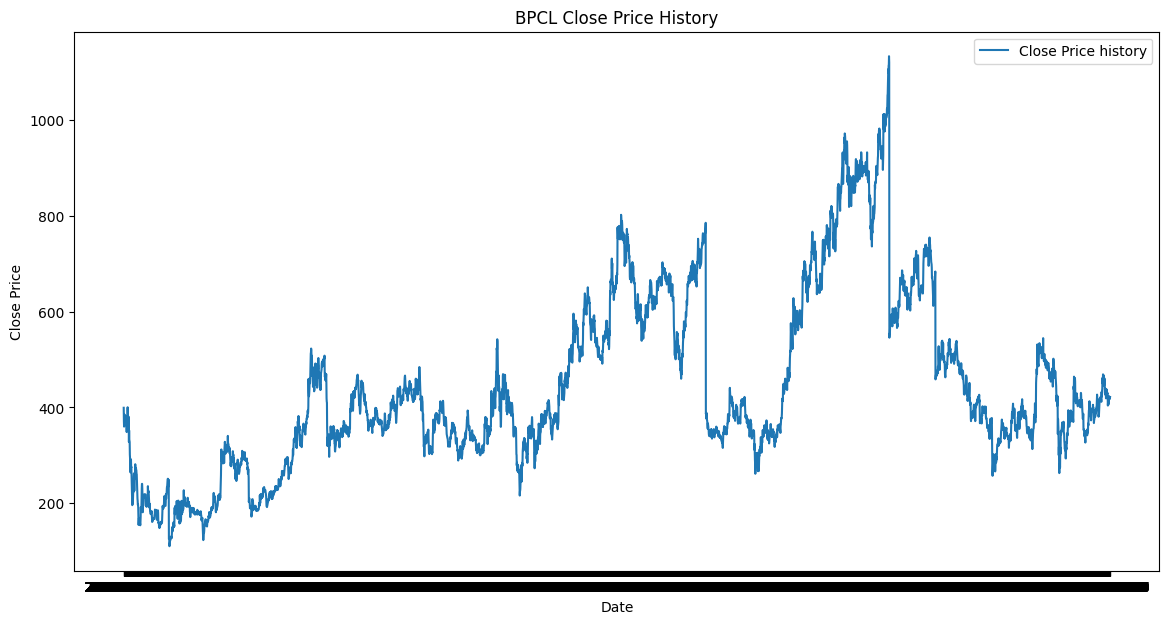

In [5]:
# Plotting the closing price history
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price history')
plt.title('BPCL Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**Step 2: Data Preprocessing**

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df = df.sort_values('Date')

In [8]:
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Fill missing values
df = df.fillna(method='ffill')

<ipython-input-8-542b54f5d9cf>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [9]:
# Feature selection
features = ['Open', 'High', 'Low', 'Close', 'Volume']
data = df[features]

# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

**Step 3: Splitting the Dataset into Training and Testing Sets**


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

sequence_length = 60
X = create_sequences(scaled_data, sequence_length)
y = scaled_data[sequence_length:, 3]  # Target is the 'Close' price

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4196, 60, 5) (1050, 60, 5) (4196,) (1050,)


**LSTM Model**

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [14]:
# Building the LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Train the model
history = lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

4196/4196 ━━━━━━━━━━━━━━━━━━━━ 118s 27ms/step - loss: 0.0044


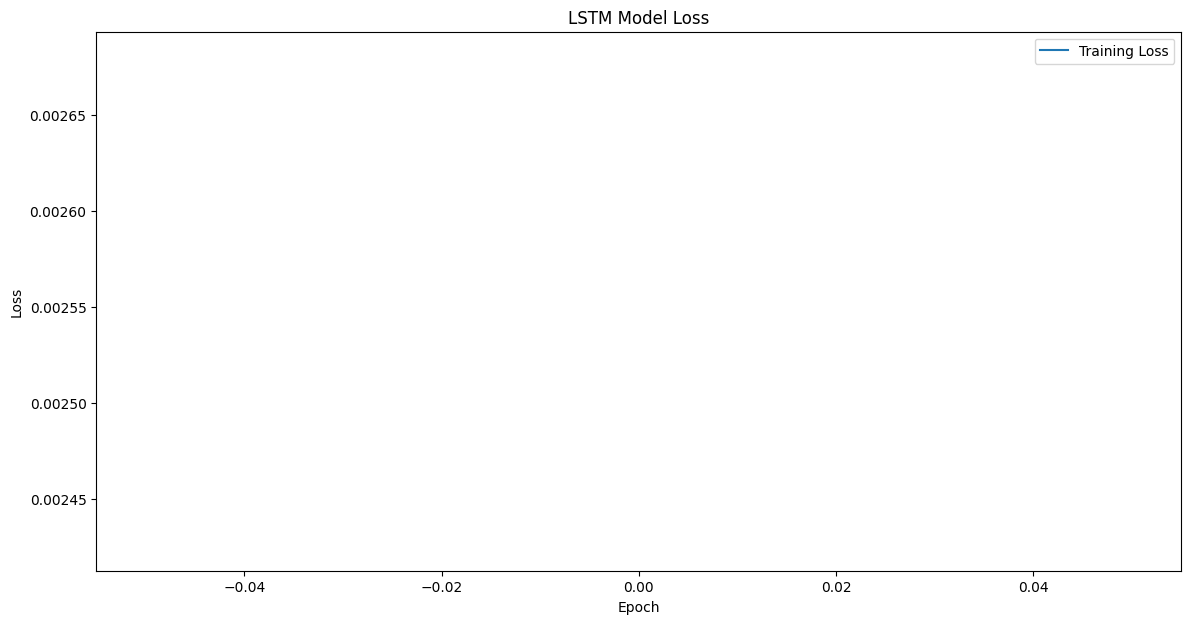

In [17]:
# Plot the loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Predicting the closing prices
predictions = lstm_model.predict(X_test)

# Reshape predictions to have the same number of features as the original data
predictions_reshaped = np.zeros((predictions.shape[0], 5))
predictions_reshaped[:, -1] = predictions.flatten()  # Assuming the closing price is the last feature

# Inverse transform the reshaped predictions
predictions = scaler.inverse_transform(predictions_reshaped)[:, -1]  # Extract the closing price

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


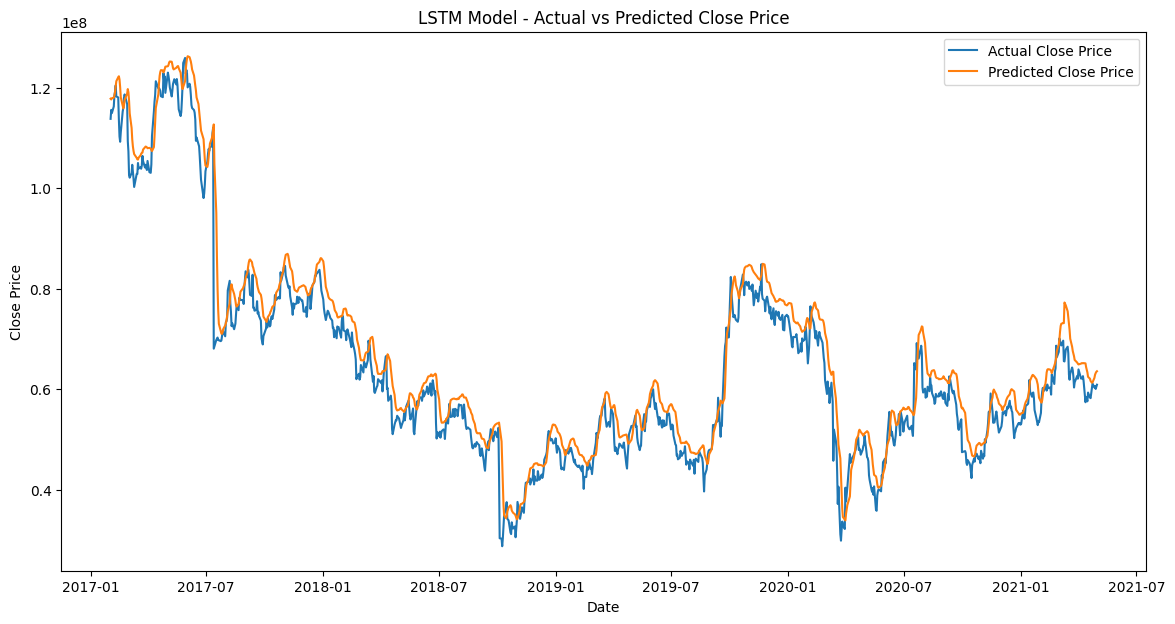

In [21]:
# Plot the results
plt.figure(figsize=(14, 7))

# Adjust the number of zeros to match the original number of features (5)
y_test_reshaped = np.concatenate((np.zeros((y_test.shape[0], 4)), y_test.reshape(-1, 1)), axis=1)

plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test_reshaped)[:, 4], label='Actual Close Price') # Extract the closing price (index 4)
plt.plot(df.index[-len(predictions):], predictions, label='Predicted Close Price')
plt.title('LSTM Model - Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**SVM Model**

In [22]:
from sklearn.svm import SVR

In [23]:
# Reshape the data for SVM
X_svm = X.reshape(X.shape[0], -1)

# Split the data
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y, test_size=0.2, shuffle=False)

In [24]:
# Create and train the SVM model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train_svm, y_train_svm)

SVR()

In [27]:
# Predicting the closing prices
predictions_svm = svm_model.predict(X_test_svm)

# Assuming your original data had 5 features, adjust the number of zeros accordingly
predictions_svm = scaler.inverse_transform(np.concatenate((np.zeros((predictions_svm.shape[0], 4)), predictions_svm.reshape(-1, 1)), axis=1))[:, 4]

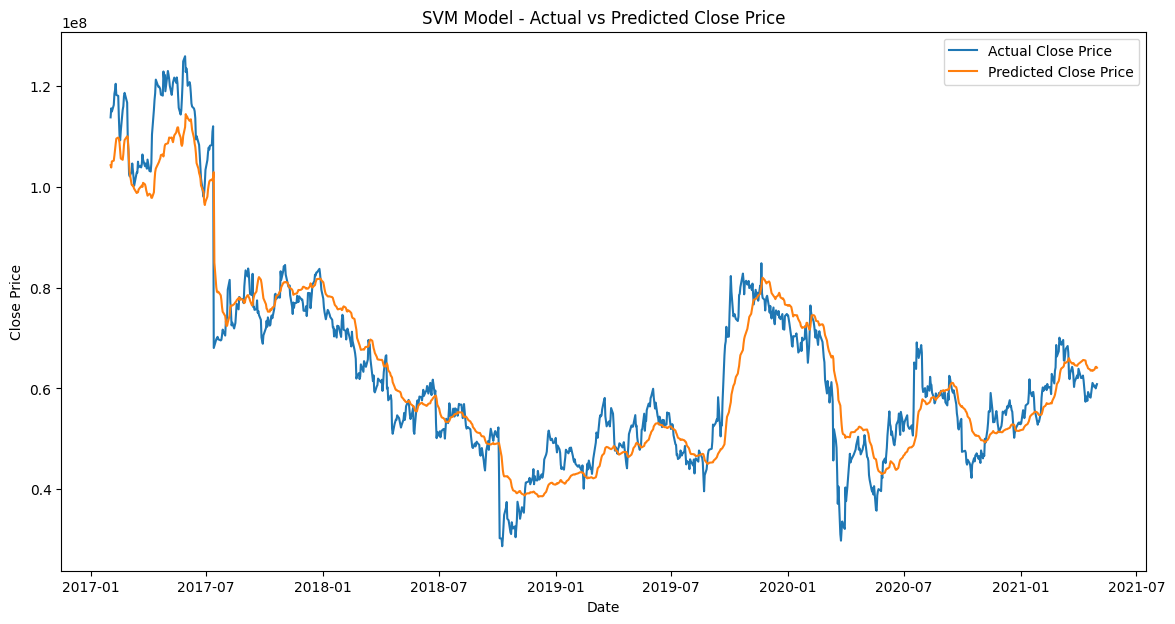

In [29]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_svm):], scaler.inverse_transform(np.concatenate((np.zeros((y_test_svm.shape[0], 4)), y_test_svm.reshape(-1, 1)), axis=1))[:, 4], label='Actual Close Price') # Changed the number of zeros to 4 to match the expected number of features
plt.plot(df.index[-len(predictions_svm):], predictions_svm, label='Predicted Close Price')
plt.title('SVM Model - Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

**K-Nearest Neighbors (KNN) Model**

In [30]:
from sklearn.neighbors import KNeighborsRegressor

In [31]:
# Create and train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_svm, y_train_svm)

KNeighborsRegressor()

In [33]:
# Predicting the closing prices
predictions_knn = knn_model.predict(X_test_svm)
# Adjust the number of zeros to match the original number of features (5)
predictions_knn = scaler.inverse_transform(np.concatenate((np.zeros((predictions_knn.shape[0], 4)), predictions_knn.reshape(-1, 1)), axis=1))[:, 4]

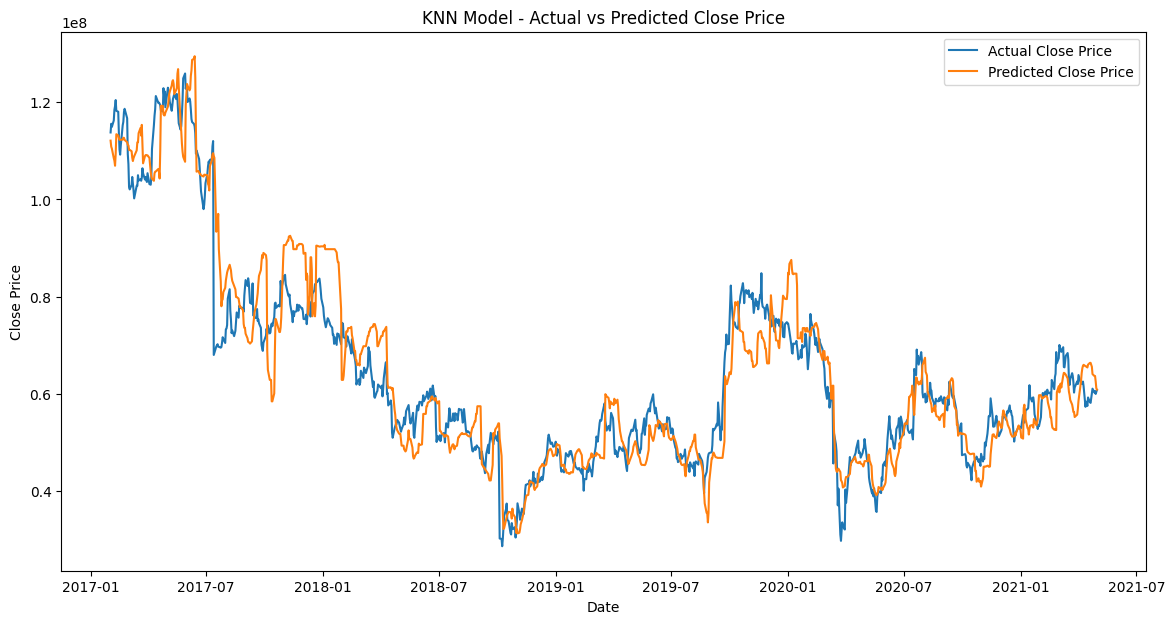

In [35]:
# Predicting the closing prices
predictions_knn = knn_model.predict(X_test_svm)
# Adjust the number of zeros to match the original number of features (5)
predictions_knn = scaler.inverse_transform(np.concatenate((np.zeros((predictions_knn.shape[0], 4)), predictions_knn.reshape(-1, 1)), axis=1))[:, 4]

# Plot the results
plt.figure(figsize=(14, 7))
# Increase the number of zeros from 3 to 4 to match the scaler's expected number of features
plt.plot(df.index[-len(y_test_svm):], scaler.inverse_transform(np.concatenate((np.zeros((y_test_svm.shape[0], 4)), y_test_svm.reshape(-1, 1)), axis=1))[:, 4], label='Actual Close Price')
plt.plot(df.index[-len(predictions_knn):], predictions_knn, label='Predicted Close Price')
plt.title('KNN Model - Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()